In [136]:
import numpy as np
from time import time
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from math import pow, sqrt

In [137]:
# Abrindo o conjunto de dados. Seperando os atributos e os rótulos de classe

data = np.loadtxt("PC1.txt", dtype='str', delimiter=',')

dataX = data[:,:-1]
dataX = dataX.astype(np.float)

dataY = data[:,-1]

In [138]:
# Obtendo o range de cada atributo para torná-los igualmente relevantes no cálculo da distância euclidiana 

maxValues = list(map(max, zip(*dataX)))
minValues = list(map(min, zip(*dataX)))

rangeValues = []
for i in range(len(maxValues)):
    rangeValues.append(maxValues[i] - minValues[i])

In [139]:
# k-NN clássico

startTest1 = time()

skf = StratifiedKFold(n_splits=10)                        # Objeto que criará os 10 folds

foldersHits1 = []                                      

for train_index, test_index in skf.split(dataX, dataY):
    
    hits = np.zeros(16)                      # Vetor que armazena a quantidade de acerto para cada 1<=k<=15 neste fold, porém somente as células ímpares são usadas
    
    for i in test_index:                        # Para cada padrão de teste, faça:
        allDist = []
        
        for j in train_index:                   # Calcule a distância do padrão de teste i para todos os de treinamento
            dist = 0
            
            for l in range(dataX.shape[1]):                               # Percorrendo o valor de todos os atributos (.shape[1] retorna o número de colunas da matriz)
                dist += pow((dataX[i,l] - dataX[j,l])/rangeValues[l],2)
                
            dist = sqrt(dist) 
            allDist.append([j, dist])                  # Vetor que armazena todas as distâncias em relação ao padrão de teste i
            
        allDist = sorted(allDist, key=lambda x: x[1])        # Ordenando do mais próximo pro mais distantes
        
        true = 0
        for k in range(1,16):
            if(dataY[allDist[k-1][0]] == "true"):              # Contagem das classes dos vizinhos mais próximos
                true += 1
        
            if(k%2==1):                                   
                if(true > k/2 and dataY[i] == "true"):    # Se o voto majoritário for true e a classe do padrão de teste for true
                    hits[k] += 1
                if(true < k/2 and dataY[i] == "false"):   # Se o voto majoritário for false e a classe do padrão de teste for false
                    hits[k] += 1
            
    foldersHits1.append(hits)                     # Armazena os acertos para cada k nesse fold

hitRate1 = np.sum(foldersHits1, axis=0)/dataX.shape[0]     # Soma os acertos de folds diferentes para um mesmo número de vizinhos e divide pela quantidade total de padrões

finishTest1 = time()
testTime1 = finishTest1 - startTest1
print("Tempo de teste k-NN classico: %.4f" %(testTime1))

Tempo de treinamento k-NN classico: 169.8677


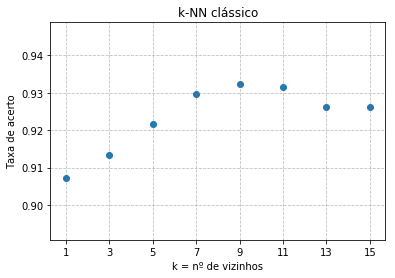

In [152]:
# Plota o gráfico da taxa de acerto para o k-NN clássico

fig = plt.figure()
plt.scatter(range(1,16,2),hitRate1[hitRate1!=0])
plt.grid(ls='--',color='gray',alpha=0.5)
plt.xticks(range(1,16,2))
plt.xlabel('k = nº de vizinhos')
plt.ylabel('Taxa de acerto')
plt.title('k-NN clássico')
fig.savefig('taxaClassic.png')

In [142]:
# k-NN ponderado

startTest2 = time()

foldersHits2 = []

for train_index, test_index in skf.split(dataX, dataY):
    
    hits = np.zeros(16)
    
    for i in test_index: 
        allDist = []
        
        for j in train_index:
            dist = 0
            
            for l in range(dataX.shape[1]):
                dist += pow((dataX[i,l] - dataX[j,l])/rangeValues[l],2)
                
            if(dist == 0):                  # Distâncias de valor 0 são substituídas por valores muito próximos de 0
                dist = pow(10,-10)
            else:
                dist = sqrt(dist) 
                
            allDist.append([j, dist])
            
        allDist = sorted(allDist, key=lambda x: x[1])
        
        true = 0
        false = 0
        for k in range(1,16):
            if(dataY[allDist[k-1][0]] == "true"):     
                true += 1/pow(allDist[k-1][1],2)         # A contribuição de cada vizinho mais próximo é ponderada pelo inverso do quadrado da distância
            else:
                false += 1/pow(allDist[k-1][1],2)
        
            if(k%2==1):
                if(true > false and dataY[i] == "true"):
                    hits[k] += 1
                if(false > true and dataY[i] == "false"):
                    hits[k] += 1
            
    foldersHits2.append(hits) 
    
hitRate2 = np.sum(foldersHits2, axis=0)/dataX.shape[0]
    
finishTest2 = time()
testTime2 = finishTest2 - startTest2
print("Tempo de teste k-NN ponderado: %.4f s" %(testTime2))

Tempo de teste k-NN ponderado: 149.8436 s


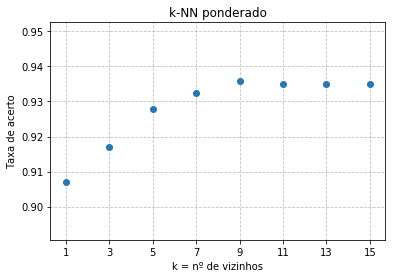

In [153]:
# Plota o gráfico da taxa de acerto para o k-NN ponderado

fig = plt.figure()
plt.scatter(range(1,16,2),hitRate2[hitRate2!=0])
plt.grid(ls='--',color='gray',alpha=0.5)
plt.xticks(range(1,16,2))
plt.xlabel('k = nº de vizinhos')
plt.ylabel('Taxa de acerto')
plt.title('k-NN ponderado')
fig.savefig('taxaPond.png')

In [144]:
# k-NN adaptativo

totalTrainTime3 = 0
totalTestTime3 = 0

foldersHits3 = []
radiusValues = np.zeros(dataX.shape[0])                # Armazenará o raio de cada padrão de treinamento (.shape[1] retorna o número de linhas da matriz)

for train_index, test_index in skf.split(dataX, dataY):
    
    hits = np.zeros(16)
    startTrain3 = time()
    
    for m in train_index:                             # Para todos os padrões de treinamento, faça:
        littlestRadius = 1
        
        for n in train_index:
            if(dataY[m] != dataY[n]):                  # Se os padrões de treinamento forem de classes distintas
            
                dist = 0
                for o in range(dataX.shape[1]):
                    dist += pow((dataX[m,o] - dataX[n,o])/rangeValues[o],2)
                
                if(dist < littlestRadius):          # Se o raio calculado for o menor de todos até o momento
                    littlestRadius = dist
                    
        if(littlestRadius == 0):                    # Se o raio tiver valor 0, substitui por um valor muito próximo de 0
            radiusValues[m] = pow(10,-10)
        else:
            radiusValues[m] = littlestRadius
    
    finishTrain3 = time()
    totalTrainTime3 += finishTrain3 - startTrain3      # Tempo total de treinamento, acumulando para cada fold
    
    startTest3 = time()
    
    for i in test_index:
        allDist = []
        
        for j in train_index:
            dist = 0
            
            for l in range(dataX.shape[1]):
                dist += pow((dataX[i,l] - dataX[j,l])/rangeValues[l],2)
                
            dist = sqrt(dist)/radiusValues[j]                  # Dividindo a distância euclidiana pelo raio correspondente
            allDist.append([j, dist])
            
        allDist = sorted(allDist, key=lambda x: x[1])
        
        true = 0
        for k in range(1,16):
            if(dataY[allDist[k-1][0]] == "true"):
                true += 1
        
            if(k%2==1):
                if(true > k/2 and dataY[i] == "true"):
                    hits[k] += 1
                if(true < k/2 and dataY[i] == "false"):
                    hits[k] += 1
            
    foldersHits3.append(hits) 
    
    finishTest3 = time()
    totalTestTime3 += finishTest3 - startTest3 

hitRate3 = np.sum(foldersHits3, axis=0)/dataX.shape[0]    
    
print("Tempo de treinamento k-NN adaptativo: %.4f s" %(totalTrainTime3))
print("Tempo de teste k-NN adaptativo: %.4f s" %(totalTestTime3))

Tempo de treinamento k-NN adaptativo: 256.5167 s
Tempo de teste k-NN adaptativo: 158.3471 s


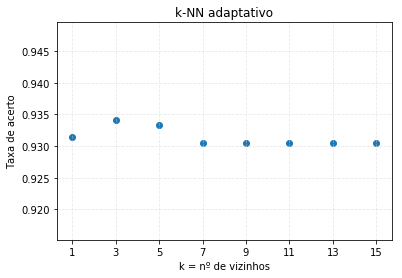

In [145]:
# Plota o gráfico da taxa de acerto para o k-NN adaptativo

fig = plt.figure()
plt.scatter(range(1,16,2),hitRate3[hitRate3!=0])
plt.grid(ls='--',color='gray',alpha=0.5)
plt.xticks(range(1,16,2))
plt.xlabel('k = nº de vizinhos')
plt.ylabel('Taxa de acerto')
plt.title('k-NN adaptativo')
fig.savefig('taxaAdap.png')